In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pandahouse as ph
import datetime
from datetime import timedelta
from operator import attrgetter
%matplotlib inline

## Необходимо построить RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию.

Воспользуемся таблицей объединенния всех датасетов (all_df). Интервалом будет служить весь промежуток времени, т.к. интервал совсем не велик. Фильтровать данные также будем по времени оплаты и статусу доставленного товара.

In [61]:
all_df.loc[all_df.order_approved_at.notna()].query('order_status == "delivered"').head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25


**Колонки, которые нам понадобятся:**
- Уникальные пользователи (customer_unique_id),
- Номера заказов (order_id),
- Время создания заказа (order_purchase_timestamp),
- Сумма покупок для каждого заказа (price).

In [63]:
df = all_df.loc[all_df.order_approved_at.notna()] \
           .query('order_status == "delivered"') \
           .groupby(['customer_unique_id', 'order_id', 'order_purchase_timestamp'], as_index=False) \
           .agg({'price':'sum'})

In [68]:
# Теперь нам необходимо установить конечную дату в зависимости от последней покупки
final_day = df.order_purchase_timestamp.max() + timedelta(days=1)
final_day

Timestamp('2018-08-30 15:00:37')

In [69]:
# Найдем дельту времени между первым и последним заказом для того, чтобы установить период
df.order_purchase_timestamp.max() - df.order_purchase_timestamp.min()

Timedelta('713 days 02:43:59')

In [70]:
# Во избежание непопадания пользователей, которые находятся на границе времени укажем период немного больше
period = 714

In [75]:
# Создадим функцию, которая рассчитает разницу между датами
diff_days = lambda x: (final_day - x).days

In [76]:
# Добавим в наш датасет колонку разницы дней и применим функцию
df['days'] = df.order_purchase_timestamp.apply(diff_days)

In [77]:
df

,customer_unique_id,order_id,order_purchase_timestamp,price,days
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-10 10:56:27,129.90,112
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-07 11:11:27,18.90,115
2,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-10 21:05:03,69.00,537
3,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-12 20:29:41,25.99,321
4,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-14 19:45:42,180.00,288
...,...,...,...,...,...
96459,fffcf5a5ff07b0908bd4e2dbc735a684,725cf8e9c24e679a8a5a32cb92c9ce1e,2017-06-08 21:00:36,1570.00,447
96460,fffea47cd6d3cc0a88bd621562a9d061,c71b9252fd7b3b263aaa4cb09319a323,2017-12-10 20:07:56,64.89,262
96461,ffff371b4d645b6ecea244b27531430a,fdc45e6c7555e6cb3cc0daca2557dbe1,2017-02-07 15:49:16,89.90,568
96462,ffff5962728ec6157033ef9805bacc48,94d3ee0bc2a0af9d4fa47a4d63616e8d,2018-05-02 15:17:41,115.00,119


**Данные подготовлены, теперь можно рассчитывать метрики**

"recency" - время от последней покупки пользователя до конечной даты

"frequency" - суммарное количество покупок у пользователя за весь период

"monetary" - сумма покупок у пользователя за весь период

In [80]:
rfm = df.groupby('customer_unique_id') \
        .agg({'days': lambda x: x.min(), \
              'order_purchase_timestamp': lambda x: len([d for d in x if d >= final_day - timedelta(days=period)]), \
              'price': 'sum'}) \
        .reset_index() \
        .rename(columns={'days': 'recency', 'order_purchase_timestamp': 'frequency', 'price': 'monetary'})

In [81]:
rfm

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90
2,0000f46a3911fa3c0805444483337064,537,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00
...,...,...,...,...
93340,fffcf5a5ff07b0908bd4e2dbc735a684,447,1,1570.00
93341,fffea47cd6d3cc0a88bd621562a9d061,262,1,64.89
93342,ffff371b4d645b6ecea244b27531430a,568,1,89.90
93343,ffff5962728ec6157033ef9805bacc48,119,1,115.00


**Следующим этапом нам предстоит определить границы метрик.**

In [86]:
# frequency
rfm.frequency.value_counts()

1     90544
2      2572
3       181
4        28
5         9
6         5
7         3
15        1
9         1
0         1
Name: frequency, dtype: int64

**Исходя из цифр определим следующие группы:**

1 - совершили одну покупку;  
2 - совершили две покупки;  
3 - совершили более двух покупок.

In [85]:
# monetary
# разобьем затраты на квантили 70-й и 95-й.
# С помощью этого мы найдем границы затрат пользователей
print(rfm.monetary.quantile(0.70))
print(rfm.monetary.quantile(0.95))

139.0
419.84800000000024


**Определим следующие группы:**

1 - потратили до 139 руб. (70% пользователей);  
2 - потратили от 139 до 420 руб. (25% пользователей);  
3 - потратили больше 420 руб. (оставшиеся 5% пользователей)

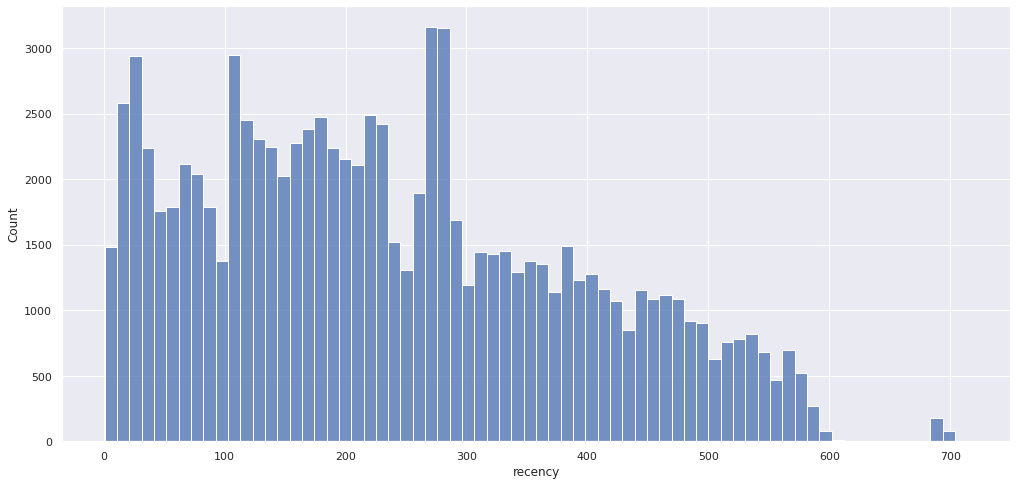

In [92]:
# recency
# Проверим гистограмму распределения
sns.histplot(rfm.recency);

Разобьем также на три примерно равные группы:   

1 - прошло больше 400 дней;  
2 - прошло от 200 до 400 дней;  
3 - прошло до 200 дней.

**Сегментация**

In [93]:
# функция оценки для метрики "recency"
def r_score(x):
    if x <= 200:
        return 3
    elif 200 < x <= 400:
        return 2
    else:
        return 1

In [94]:
# функция оценки для метрики "frequency"
def f_score(x):
    if x > 2:
        return 3
    elif x == 2:
        return 2
    else:
        return 1

In [95]:
# функция оценки для метрики "monetary"
def m_score(x):
    if x >= 420:
        return 3
    elif 420 > x >= 139:
        return 2
    else:
        return 1

In [96]:
# Применяем функции для создания столбцов с оценками
rfm['R'] = rfm['recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['frequency'].apply(lambda x: f_score(x))
rfm['M'] = rfm['monetary'].apply(lambda x: m_score(x))

In [98]:
# Объединяем оценки R, F и M в общую оценку RFM
rfm['RFM'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)

In [101]:
# Всего 27 сегментов
rfm.RFM.nunique()

27

In [105]:
# Зададим девять сегментов на основе метрик F и M.
segt_map = {
    r'11': 'Стандарт', # Купил 1 раз
    r'12': 'Заинтересованный', # Вернулся второй раз
    r'13': 'Уникальный/скупой', # Возвращался более двух раз, но оставленная сумму не большая
    r'21': 'Стандартный/денежный', # Пришел один раз, но оставил большую сумму
    r'22': 'Выше среднего', # Вернулся за покупкой и потратил большую сумму
    r'23': 'Уникальный/денежный', # Возвращался более двух раз и оставил большую сумму 
    r'31': 'Стандартный/богатый', # Пришел один раз и оставил огромную сумму
    r'32': 'Заинтересованный богач', # Вернулся за покупкой и потратил огромную сумму
    r'33': 'Уникальный богач!' # Возвращался более двух раз и потратил огромную сумму
}

In [106]:
# Создаем колонку с названием сегмента для каждого уникального пользователя
rfm['segment'] = rfm['M'].map(str) + rfm['F'].map(str)
rfm['segment'] = rfm['segment'].replace(segt_map, regex=True)

In [107]:
rfm

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,3,1,1,311,Стандарт
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,3,1,1,311,Стандарт
2,0000f46a3911fa3c0805444483337064,537,1,69.00,1,1,1,111,Стандарт
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,2,1,1,211,Стандарт
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2,1,2,212,Стандартный/денежный
...,...,...,...,...,...,...,...,...,...
93340,fffcf5a5ff07b0908bd4e2dbc735a684,447,1,1570.00,1,1,3,113,Стандартный/богатый
93341,fffea47cd6d3cc0a88bd621562a9d061,262,1,64.89,2,1,1,211,Стандарт
93342,ffff371b4d645b6ecea244b27531430a,568,1,89.90,1,1,1,111,Стандарт
93343,ffff5962728ec6157033ef9805bacc48,119,1,115.00,3,1,1,311,Стандарт


In [108]:
rfm.segment.value_counts().reset_index()

,index,segment
0,Стандарт,64272
1,Стандартный/денежный,22031
2,Стандартный/богатый,4242
3,Выше среднего,1325
4,Заинтересованный,935
5,Заинтересованный богач,312
6,Уникальный/денежный,103
7,Уникальный богач!,83
8,Уникальный/скупой,42


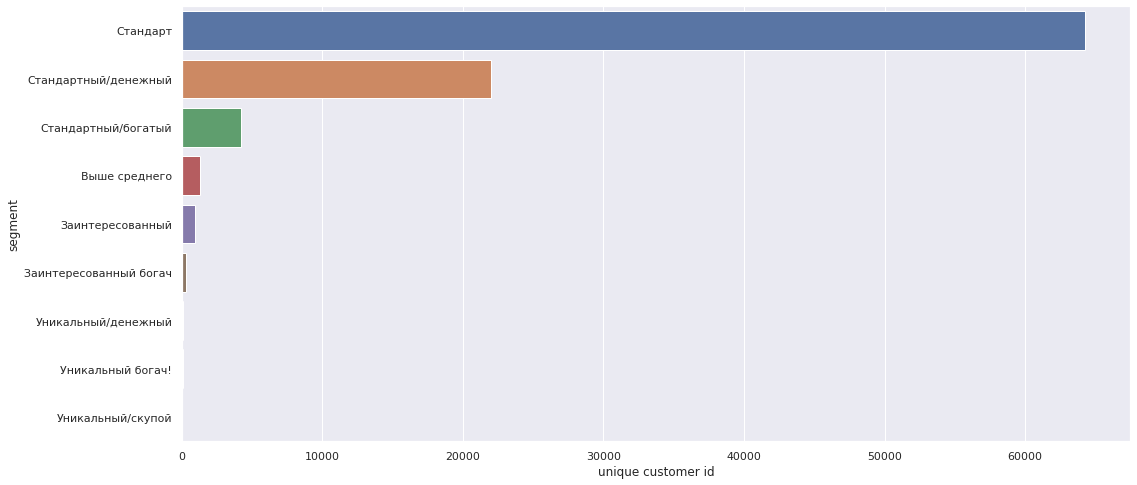

In [109]:
# Визуализация
sns.barplot(x=rfm.segment.value_counts().reset_index()['segment'], y=rfm.segment.value_counts().reset_index()['index'])
plt.xlabel('unique customer id')
plt.ylabel('segment');